In [1]:
import numpy as np
import networkx as nx
!pip install torch_geometric
import torch_geometric
from torch_geometric.utils import to_networkx
from IPython.display import clear_output
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
clear_output()

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from torch_geometric.nn import GraphConv, TopKPooling, TransformerConv, GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch.nn import Linear, BatchNorm1d, ModuleList
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score

In [63]:
dataset = torch_geometric.datasets.TUDataset(root = "knowl_repr", name = "PROTEINS", cleaned = True, use_edge_attr = True, use_node_attr  = True)

clear_output()

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [65]:
from torch_geometric.data import DataLoader

test_ratio = 0.3 # Ratio for splitting dataset
batch_size = 20
n = int(len(dataset) * test_ratio)
dataset = dataset.shuffle()
test_dataset = dataset[:n]
train_dataset = dataset[n:]
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [89]:
class SimpleModel(torch.nn.Module):
  def __init__(self, *args, **kwargs) -> None:
      super().__init__(*args, **kwargs)
      self.lin1 = Linear(4, 32)
      self.bn1 = torch.nn.BatchNorm1d(32)
      self.drop1 = torch.nn.Dropout(0.3)
      self.lin2 = Linear(32, 32)
      self.bn2 = torch.nn.BatchNorm1d(32)
      self.drop2 = torch.nn.Dropout(0.3)
      self.lin3 = Linear(32, 2)
  def forward(self, x, edge_index, batch, edge_weight=None):
      x = global_mean_pool(x, batch) # batch_size x 4
      x = torch.relu(self.bn1(self.lin1(x)))
      x = self.drop1(x)
      x = torch.relu(self.bn2(self.lin2(x)))
      x = self.drop2(x)
      x = torch.softmax(self.lin3(x), dim = 1)
      return x

In [90]:
model = SimpleModel().to(device)
#%% Loss and Optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def train(epoch):
    all_preds = []
    all_labels = []
    for data in tqdm(train_loader):
        data = data.to(device)

        x, edge_index, batch = data.x, data.edge_index, data.batch
        labels = data.y

        optimizer.zero_grad()

        pred = model(x,edge_index, batch)

        loss = loss_fn(pred.float(), labels)

        loss.backward()
        optimizer.step()

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(labels.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss

def test(epoch):
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)

        x, edge_index, batch = data.x, data.edge_index, data.batch
        labels = data.y

        pred = model(x,edge_index, batch)

        loss = loss_fn(pred.float(), labels)

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(labels.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(f"Predictions are {all_preds}")
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")

losses_train = []
losses_val = []
for epoch in range(100):
        # Training
        model.train()
        loss = train(epoch=epoch)
        losses_train.append(loss.item())
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")

        # Testing
        model.eval()
        if epoch % 5 == 0:
            loss = test(epoch=epoch)
            losses_val.append(loss.item())
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")

100%|██████████| 35/35 [00:00<00:00, 83.50it/s]



 Confusion matrix: 
 [[234  98]
 [210 141]]
F1 Score: 0.47796610169491527
Accuracy: 0.5490483162518301
Precision: 0.5899581589958159
Recall: 0.4017094017094017
Epoch 0 | Train Loss 0.9059335589408875
Predictions are [0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[165  62]
 [ 23  42]]
F1 Score: 0.49704142011834324
Accuracy: 0.708904109589041
Precision: 0.40384615384615385
Recall: 0.6461538461538462
Epoch 0 | Test Loss 0.6630496

100%|██████████| 35/35 [00:00<00:00, 68.48it/s]



 Confusion matrix: 
 [[371 131]
 [ 73 108]]
F1 Score: 0.5142857142857143
Accuracy: 0.7013177159590044
Precision: 0.45188284518828453
Recall: 0.5966850828729282
Epoch 1 | Train Loss 0.8716082572937012


100%|██████████| 35/35 [00:00<00:00, 73.00it/s]



 Confusion matrix: 
 [[376 137]
 [ 68 102]]
F1 Score: 0.49877750611246946
Accuracy: 0.6998535871156661
Precision: 0.42677824267782427
Recall: 0.6
Epoch 2 | Train Loss 0.766960084438324


100%|██████████| 35/35 [00:00<00:00, 70.29it/s]



 Confusion matrix: 
 [[382 143]
 [ 62  96]]
F1 Score: 0.4836272040302267
Accuracy: 0.6998535871156661
Precision: 0.401673640167364
Recall: 0.6075949367088608
Epoch 3 | Train Loss 0.7354667782783508


100%|██████████| 35/35 [00:00<00:00, 65.36it/s]



 Confusion matrix: 
 [[378 145]
 [ 66  94]]
F1 Score: 0.4711779448621554
Accuracy: 0.6910688140556369
Precision: 0.39330543933054396
Recall: 0.5875
Epoch 4 | Train Loss 0.727836549282074


100%|██████████| 35/35 [00:00<00:00, 66.99it/s]



 Confusion matrix: 
 [[388 136]
 [ 56 103]]
F1 Score: 0.5175879396984925
Accuracy: 0.718887262079063
Precision: 0.4309623430962343
Recall: 0.6477987421383647
Epoch 5 | Train Loss 0.6624409556388855
Predictions are [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[156  57]
 [ 32  47]]
F1 Score: 0.5136612021857923
Accuracy: 0.6952054794520548
Precision: 0.4519230769230769
Recall: 0.5949367088607594
Epoch 5 | Test Loss 0.5406238436

100%|██████████| 35/35 [00:00<00:00, 126.42it/s]



 Confusion matrix: 
 [[382 138]
 [ 62 101]]
F1 Score: 0.5024875621890547
Accuracy: 0.7071742313323572
Precision: 0.4225941422594142
Recall: 0.6196319018404908
Epoch 6 | Train Loss 0.7006198763847351


100%|██████████| 35/35 [00:00<00:00, 174.06it/s]



 Confusion matrix: 
 [[387 135]
 [ 57 104]]
F1 Score: 0.52
Accuracy: 0.718887262079063
Precision: 0.4351464435146444
Recall: 0.6459627329192547
Epoch 7 | Train Loss 0.834406852722168


100%|██████████| 35/35 [00:00<00:00, 236.30it/s]



 Confusion matrix: 
 [[389 134]
 [ 55 105]]
F1 Score: 0.5263157894736842
Accuracy: 0.7232796486090776
Precision: 0.4393305439330544
Recall: 0.65625
Epoch 8 | Train Loss 0.8506906032562256


100%|██████████| 35/35 [00:00<00:00, 204.00it/s]



 Confusion matrix: 
 [[394 141]
 [ 50  98]]
F1 Score: 0.5064599483204134
Accuracy: 0.7203513909224012
Precision: 0.4100418410041841
Recall: 0.6621621621621622
Epoch 9 | Train Loss 0.7342832684516907


100%|██████████| 35/35 [00:00<00:00, 226.45it/s]



 Confusion matrix: 
 [[386 137]
 [ 58 102]]
F1 Score: 0.5112781954887218
Accuracy: 0.7144948755490483
Precision: 0.42677824267782427
Recall: 0.6375
Epoch 10 | Train Loss 0.8316812515258789
Predictions are [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[159  59]
 [ 29  45]]
F1 Score: 0.5056179775280899
Accuracy: 0.6986301369863014
Precision: 0.4326923076923077
Recall: 0.6081081081081081
Epoch 10 | Test Loss 0.5297242999076843


100%|██████████| 35/35 [00:00<00:00, 213.32it/s]



 Confusion matrix: 
 [[389 138]
 [ 55 101]]
F1 Score: 0.5113924050632911
Accuracy: 0.7174231332357247
Precision: 0.4225941422594142
Recall: 0.6474358974358975
Epoch 11 | Train Loss 0.9811453819274902


100%|██████████| 35/35 [00:00<00:00, 230.60it/s]



 Confusion matrix: 
 [[380 131]
 [ 64 108]]
F1 Score: 0.5255474452554745
Accuracy: 0.7144948755490483
Precision: 0.45188284518828453
Recall: 0.627906976744186
Epoch 12 | Train Loss 0.7995319366455078


100%|██████████| 35/35 [00:00<00:00, 224.10it/s]



 Confusion matrix: 
 [[387 136]
 [ 57 103]]
F1 Score: 0.5162907268170426
Accuracy: 0.7174231332357247
Precision: 0.4309623430962343
Recall: 0.64375
Epoch 13 | Train Loss 0.7573361396789551


100%|██████████| 35/35 [00:00<00:00, 214.24it/s]



 Confusion matrix: 
 [[377 132]
 [ 67 107]]
F1 Score: 0.5181598062953995
Accuracy: 0.7086383601756955
Precision: 0.4476987447698745
Recall: 0.6149425287356322
Epoch 14 | Train Loss 0.7721577286720276


100%|██████████| 35/35 [00:00<00:00, 229.07it/s]



 Confusion matrix: 
 [[379 130]
 [ 65 109]]
F1 Score: 0.5278450363196125
Accuracy: 0.7144948755490483
Precision: 0.4560669456066946
Recall: 0.6264367816091954
Epoch 15 | Train Loss 0.7834954261779785
Predictions are [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[153  52]
 [ 35  52]]
F1 Score: 0.5445026178010471
Accuracy: 0.702054794520548
Precision: 0.5
Recall: 0.5977011494252874
Epoch 15 | Test Loss 0.5248971581459045


100%|██████████| 35/35 [00:00<00:00, 222.01it/s]



 Confusion matrix: 
 [[379 127]
 [ 65 112]]
F1 Score: 0.5384615384615384
Accuracy: 0.718887262079063
Precision: 0.4686192468619247
Recall: 0.632768361581921
Epoch 16 | Train Loss 0.6720073223114014


100%|██████████| 35/35 [00:00<00:00, 233.57it/s]



 Confusion matrix: 
 [[373 129]
 [ 71 110]]
F1 Score: 0.5238095238095238
Accuracy: 0.7071742313323572
Precision: 0.4602510460251046
Recall: 0.6077348066298343
Epoch 17 | Train Loss 0.6928609013557434


100%|██████████| 35/35 [00:00<00:00, 216.14it/s]



 Confusion matrix: 
 [[386 137]
 [ 58 102]]
F1 Score: 0.5112781954887218
Accuracy: 0.7144948755490483
Precision: 0.42677824267782427
Recall: 0.6375
Epoch 18 | Train Loss 0.4999649226665497


100%|██████████| 35/35 [00:00<00:00, 228.20it/s]



 Confusion matrix: 
 [[382 124]
 [ 62 115]]
F1 Score: 0.5528846153846153
Accuracy: 0.7276720351390923
Precision: 0.4811715481171548
Recall: 0.6497175141242938
Epoch 19 | Train Loss 0.6991556286811829


100%|██████████| 35/35 [00:00<00:00, 219.05it/s]



 Confusion matrix: 
 [[376 136]
 [ 68 103]]
F1 Score: 0.5024390243902439
Accuracy: 0.7013177159590044
Precision: 0.4309623430962343
Recall: 0.6023391812865497
Epoch 20 | Train Loss 0.6511202454566956
Predictions are [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[152  52]
 [ 36  52]]
F1 Score: 0.5416666666666667
Accuracy: 0.6986301369863014
Precision: 0.5
Recall: 0.5909090909090909
Epoch 20 | Test Loss 0.5354630947113037


100%|██████████| 35/35 [00:00<00:00, 220.85it/s]



 Confusion matrix: 
 [[374 134]
 [ 70 105]]
F1 Score: 0.5072463768115942
Accuracy: 0.7013177159590044
Precision: 0.4393305439330544
Recall: 0.6
Epoch 21 | Train Loss 0.8507350087165833


100%|██████████| 35/35 [00:00<00:00, 226.72it/s]



 Confusion matrix: 
 [[383 126]
 [ 61 113]]
F1 Score: 0.5472154963680388
Accuracy: 0.726207906295754
Precision: 0.47280334728033474
Recall: 0.6494252873563219
Epoch 22 | Train Loss 0.6929309964179993


100%|██████████| 35/35 [00:00<00:00, 237.49it/s]



 Confusion matrix: 
 [[378 125]
 [ 66 114]]
F1 Score: 0.5441527446300717
Accuracy: 0.7203513909224012
Precision: 0.4769874476987448
Recall: 0.6333333333333333
Epoch 23 | Train Loss 0.6949625015258789


100%|██████████| 35/35 [00:00<00:00, 210.04it/s]



 Confusion matrix: 
 [[394 124]
 [ 50 115]]
F1 Score: 0.5693069306930693
Accuracy: 0.7452415812591509
Precision: 0.4811715481171548
Recall: 0.696969696969697
Epoch 24 | Train Loss 0.654346227645874


100%|██████████| 35/35 [00:00<00:00, 127.75it/s]



 Confusion matrix: 
 [[378 136]
 [ 66 103]]
F1 Score: 0.5049019607843137
Accuracy: 0.7042459736456809
Precision: 0.4309623430962343
Recall: 0.6094674556213018
Epoch 25 | Train Loss 0.5820230841636658
Predictions are [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[154  53]
 [ 34  51]]
F1 Score: 0.5396825396825397
Accuracy: 0.702054794520548
Precision: 0.49038461538461536
Recall: 0.6
Epoch 25 | Test Loss 0.540989100933075


100%|██████████| 35/35 [00:00<00:00, 148.60it/s]



 Confusion matrix: 
 [[386 126]
 [ 58 113]]
F1 Score: 0.551219512195122
Accuracy: 0.7306002928257687
Precision: 0.47280334728033474
Recall: 0.6608187134502924
Epoch 26 | Train Loss 0.7561115622520447


100%|██████████| 35/35 [00:00<00:00, 159.45it/s]



 Confusion matrix: 
 [[384 128]
 [ 60 111]]
F1 Score: 0.5414634146341464
Accuracy: 0.7247437774524158
Precision: 0.46443514644351463
Recall: 0.6491228070175439
Epoch 27 | Train Loss 0.6562480330467224


100%|██████████| 35/35 [00:00<00:00, 158.85it/s]



 Confusion matrix: 
 [[384 121]
 [ 60 118]]
F1 Score: 0.565947242206235
Accuracy: 0.7349926793557833
Precision: 0.49372384937238495
Recall: 0.6629213483146067
Epoch 28 | Train Loss 0.9396636486053467


100%|██████████| 35/35 [00:00<00:00, 149.13it/s]



 Confusion matrix: 
 [[383 127]
 [ 61 112]]
F1 Score: 0.5436893203883495
Accuracy: 0.7247437774524158
Precision: 0.4686192468619247
Recall: 0.6473988439306358
Epoch 29 | Train Loss 0.6775519251823425


100%|██████████| 35/35 [00:00<00:00, 147.11it/s]



 Confusion matrix: 
 [[385 127]
 [ 59 112]]
F1 Score: 0.5463414634146342
Accuracy: 0.7276720351390923
Precision: 0.4686192468619247
Recall: 0.6549707602339181
Epoch 30 | Train Loss 0.8846418857574463
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[151  49]
 [ 37  55]]
F1 Score: 0.5612244897959183
Accuracy: 0.7054794520547946
Precision: 0.5288461538461539
Recall: 0.5978260869565217
Epoch 30 | Test Loss 0.5396320

100%|██████████| 35/35 [00:00<00:00, 164.46it/s]



 Confusion matrix: 
 [[383 123]
 [ 61 116]]
F1 Score: 0.5576923076923077
Accuracy: 0.7306002928257687
Precision: 0.48535564853556484
Recall: 0.655367231638418
Epoch 31 | Train Loss 0.7349813580513


100%|██████████| 35/35 [00:00<00:00, 165.99it/s]



 Confusion matrix: 
 [[386 127]
 [ 58 112]]
F1 Score: 0.547677261613692
Accuracy: 0.7291361639824304
Precision: 0.4686192468619247
Recall: 0.6588235294117647
Epoch 32 | Train Loss 0.8510618805885315


100%|██████████| 35/35 [00:00<00:00, 148.17it/s]



 Confusion matrix: 
 [[378 123]
 [ 66 116]]
F1 Score: 0.5510688836104513
Accuracy: 0.7232796486090776
Precision: 0.48535564853556484
Recall: 0.6373626373626373
Epoch 33 | Train Loss 0.6629399061203003


100%|██████████| 35/35 [00:00<00:00, 144.83it/s]



 Confusion matrix: 
 [[392 117]
 [ 52 122]]
F1 Score: 0.5907990314769975
Accuracy: 0.7525622254758418
Precision: 0.5104602510460251
Recall: 0.7011494252873564
Epoch 34 | Train Loss 0.6300567984580994


100%|██████████| 35/35 [00:00<00:00, 151.24it/s]



 Confusion matrix: 
 [[380 121]
 [ 64 118]]
F1 Score: 0.5605700712589073
Accuracy: 0.7291361639824304
Precision: 0.49372384937238495
Recall: 0.6483516483516484
Epoch 35 | Train Loss 0.511191189289093
Predictions are [1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[156  57]
 [ 32  47]]
F1 Score: 0.5136612021857923
Accuracy: 0.6952054794520548
Precision: 0.4519230769230769
Recall: 0.5949367088607594
Epoch 35 | Test Loss 0.5510761

100%|██████████| 35/35 [00:00<00:00, 131.77it/s]



 Confusion matrix: 
 [[378 118]
 [ 66 121]]
F1 Score: 0.568075117370892
Accuracy: 0.7306002928257687
Precision: 0.5062761506276151
Recall: 0.6470588235294118
Epoch 36 | Train Loss 0.4016631841659546


100%|██████████| 35/35 [00:00<00:00, 131.24it/s]



 Confusion matrix: 
 [[379 123]
 [ 65 116]]
F1 Score: 0.5523809523809524
Accuracy: 0.7247437774524158
Precision: 0.48535564853556484
Recall: 0.6408839779005525
Epoch 37 | Train Loss 0.6997659802436829


100%|██████████| 35/35 [00:00<00:00, 129.59it/s]



 Confusion matrix: 
 [[381 125]
 [ 63 114]]
F1 Score: 0.5480769230769231
Accuracy: 0.7247437774524158
Precision: 0.4769874476987448
Recall: 0.6440677966101694
Epoch 38 | Train Loss 0.5171721577644348


100%|██████████| 35/35 [00:00<00:00, 123.95it/s]



 Confusion matrix: 
 [[377 116]
 [ 67 123]]
F1 Score: 0.5734265734265734
Accuracy: 0.7320644216691069
Precision: 0.5146443514644351
Recall: 0.6473684210526316
Epoch 39 | Train Loss 0.6993679404258728


100%|██████████| 35/35 [00:00<00:00, 147.22it/s]



 Confusion matrix: 
 [[390 117]
 [ 54 122]]
F1 Score: 0.5879518072289156
Accuracy: 0.7496339677891655
Precision: 0.5104602510460251
Recall: 0.6931818181818182
Epoch 40 | Train Loss 0.6281713843345642
Predictions are [1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[156  56]
 [ 32  48]]
F1 Score: 0.5217391304347826
Accuracy: 0.6986301369863014
Precision: 0.46153846153846156
Recall: 0.6
Epoch 40 | Test Loss 0.5498514771461487


100%|██████████| 35/35 [00:00<00:00, 160.88it/s]



 Confusion matrix: 
 [[380 126]
 [ 64 113]]
F1 Score: 0.5432692307692308
Accuracy: 0.7218155197657394
Precision: 0.47280334728033474
Recall: 0.6384180790960452
Epoch 41 | Train Loss 0.7092000842094421


100%|██████████| 35/35 [00:00<00:00, 164.42it/s]



 Confusion matrix: 
 [[382 123]
 [ 62 116]]
F1 Score: 0.5563549160671464
Accuracy: 0.7291361639824304
Precision: 0.48535564853556484
Recall: 0.651685393258427
Epoch 42 | Train Loss 0.5165677666664124


100%|██████████| 35/35 [00:00<00:00, 155.18it/s]



 Confusion matrix: 
 [[377 123]
 [ 67 116]]
F1 Score: 0.5497630331753555
Accuracy: 0.7218155197657394
Precision: 0.48535564853556484
Recall: 0.6338797814207651
Epoch 43 | Train Loss 0.4854167401790619


100%|██████████| 35/35 [00:00<00:00, 134.25it/s]



 Confusion matrix: 
 [[381 120]
 [ 63 119]]
F1 Score: 0.5653206650831355
Accuracy: 0.7320644216691069
Precision: 0.497907949790795
Recall: 0.6538461538461539
Epoch 44 | Train Loss 0.6149992346763611


100%|██████████| 35/35 [00:00<00:00, 158.36it/s]



 Confusion matrix: 
 [[379 123]
 [ 65 116]]
F1 Score: 0.5523809523809524
Accuracy: 0.7247437774524158
Precision: 0.48535564853556484
Recall: 0.6408839779005525
Epoch 45 | Train Loss 0.6865747570991516
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[152  48]
 [ 36  56]]
F1 Score: 0.5714285714285715
Accuracy: 0.7123287671232876
Precision: 0.5384615384615384
Recall: 0.6086956521739131
Epoch 45 | Test Loss 0.526848

100%|██████████| 35/35 [00:00<00:00, 144.17it/s]



 Confusion matrix: 
 [[385 126]
 [ 59 113]]
F1 Score: 0.5498783454987834
Accuracy: 0.7291361639824304
Precision: 0.47280334728033474
Recall: 0.6569767441860465
Epoch 46 | Train Loss 0.694793164730072


100%|██████████| 35/35 [00:00<00:00, 109.78it/s]



 Confusion matrix: 
 [[378 124]
 [ 66 115]]
F1 Score: 0.5476190476190477
Accuracy: 0.7218155197657394
Precision: 0.4811715481171548
Recall: 0.6353591160220995
Epoch 47 | Train Loss 0.5950330495834351


100%|██████████| 35/35 [00:00<00:00, 107.09it/s]



 Confusion matrix: 
 [[380 117]
 [ 64 122]]
F1 Score: 0.5741176470588235
Accuracy: 0.7349926793557833
Precision: 0.5104602510460251
Recall: 0.6559139784946236
Epoch 48 | Train Loss 0.6618186235427856


100%|██████████| 35/35 [00:00<00:00, 120.27it/s]



 Confusion matrix: 
 [[375 117]
 [ 69 122]]
F1 Score: 0.5674418604651164
Accuracy: 0.7276720351390923
Precision: 0.5104602510460251
Recall: 0.6387434554973822
Epoch 49 | Train Loss 0.56272953748703


100%|██████████| 35/35 [00:00<00:00, 136.65it/s]



 Confusion matrix: 
 [[365 109]
 [ 79 130]]
F1 Score: 0.5803571428571429
Accuracy: 0.7247437774524158
Precision: 0.5439330543933054
Recall: 0.6220095693779905
Epoch 50 | Train Loss 0.6515082716941833
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[147  45]
 [ 41  59]]
F1 Score: 0.5784313725490196
Accuracy: 0.7054794520547946
Precision: 0.5673076923076923
Recall: 0.59
Epoch 50 | Test Loss 0.5231608748435974


100%|██████████| 35/35 [00:00<00:00, 140.88it/s]



 Confusion matrix: 
 [[369 118]
 [ 75 121]]
F1 Score: 0.5563218390804598
Accuracy: 0.7174231332357247
Precision: 0.5062761506276151
Recall: 0.6173469387755102
Epoch 51 | Train Loss 0.6441592574119568


100%|██████████| 35/35 [00:00<00:00, 121.48it/s]



 Confusion matrix: 
 [[374 111]
 [ 70 128]]
F1 Score: 0.585812356979405
Accuracy: 0.7349926793557833
Precision: 0.5355648535564853
Recall: 0.6464646464646465
Epoch 52 | Train Loss 0.6417063474655151


100%|██████████| 35/35 [00:00<00:00, 99.55it/s] 



 Confusion matrix: 
 [[377 117]
 [ 67 122]]
F1 Score: 0.5700934579439252
Accuracy: 0.7306002928257687
Precision: 0.5104602510460251
Recall: 0.6455026455026455
Epoch 53 | Train Loss 0.6680009365081787


100%|██████████| 35/35 [00:00<00:00, 113.14it/s]



 Confusion matrix: 
 [[371 116]
 [ 73 123]]
F1 Score: 0.5655172413793103
Accuracy: 0.7232796486090776
Precision: 0.5146443514644351
Recall: 0.6275510204081632
Epoch 54 | Train Loss 0.5839939117431641


100%|██████████| 35/35 [00:00<00:00, 159.27it/s]



 Confusion matrix: 
 [[372 121]
 [ 72 118]]
F1 Score: 0.5501165501165501
Accuracy: 0.7174231332357247
Precision: 0.49372384937238495
Recall: 0.6210526315789474
Epoch 55 | Train Loss 0.6469091773033142
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[149  47]
 [ 39  57]]
F1 Score: 0.5700000000000001
Accuracy: 0.7054794520547946
Precision: 0.5480769230769231
Recall: 0.59375
Epoch 55 | Test Loss 0.525300145149231


100%|██████████| 35/35 [00:00<00:00, 151.73it/s]



 Confusion matrix: 
 [[378 116]
 [ 66 123]]
F1 Score: 0.5747663551401869
Accuracy: 0.7335285505124451
Precision: 0.5146443514644351
Recall: 0.6507936507936508
Epoch 56 | Train Loss 0.6296748518943787


100%|██████████| 35/35 [00:00<00:00, 148.08it/s]



 Confusion matrix: 
 [[380 110]
 [ 64 129]]
F1 Score: 0.5972222222222222
Accuracy: 0.7452415812591509
Precision: 0.5397489539748954
Recall: 0.6683937823834197
Epoch 57 | Train Loss 0.524440586566925


100%|██████████| 35/35 [00:00<00:00, 140.29it/s]



 Confusion matrix: 
 [[370 119]
 [ 74 120]]
F1 Score: 0.5542725173210161
Accuracy: 0.7174231332357247
Precision: 0.502092050209205
Recall: 0.6185567010309279
Epoch 58 | Train Loss 0.7189574241638184


100%|██████████| 35/35 [00:00<00:00, 133.71it/s]



 Confusion matrix: 
 [[376 112]
 [ 68 127]]
F1 Score: 0.5852534562211982
Accuracy: 0.7364568081991215
Precision: 0.5313807531380753
Recall: 0.6512820512820513
Epoch 59 | Train Loss 0.46545401215553284


100%|██████████| 35/35 [00:00<00:00, 135.51it/s]



 Confusion matrix: 
 [[376 117]
 [ 68 122]]
F1 Score: 0.5687645687645687
Accuracy: 0.7291361639824304
Precision: 0.5104602510460251
Recall: 0.6421052631578947
Epoch 60 | Train Loss 0.44246551394462585
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[146  47]
 [ 42  57]]
F1 Score: 0.5615763546798029
Accuracy: 0.6952054794520548
Precision: 0.5480769230769231
Recall: 0.5757575757575758
Epoch 60 | Test Loss 0.521228

100%|██████████| 35/35 [00:00<00:00, 135.05it/s]



 Confusion matrix: 
 [[373 117]
 [ 71 122]]
F1 Score: 0.5648148148148149
Accuracy: 0.7247437774524158
Precision: 0.5104602510460251
Recall: 0.6321243523316062
Epoch 61 | Train Loss 0.868147075176239


100%|██████████| 35/35 [00:00<00:00, 198.19it/s]



 Confusion matrix: 
 [[370 109]
 [ 74 130]]
F1 Score: 0.5869074492099323
Accuracy: 0.7320644216691069
Precision: 0.5439330543933054
Recall: 0.6372549019607843
Epoch 62 | Train Loss 0.6974942088127136


100%|██████████| 35/35 [00:00<00:00, 219.50it/s]



 Confusion matrix: 
 [[380 116]
 [ 64 123]]
F1 Score: 0.5774647887323944
Accuracy: 0.7364568081991215
Precision: 0.5146443514644351
Recall: 0.6577540106951871
Epoch 63 | Train Loss 0.6667298674583435


100%|██████████| 35/35 [00:00<00:00, 229.23it/s]



 Confusion matrix: 
 [[377 117]
 [ 67 122]]
F1 Score: 0.5700934579439252
Accuracy: 0.7306002928257687
Precision: 0.5104602510460251
Recall: 0.6455026455026455
Epoch 64 | Train Loss 0.3803638517856598


100%|██████████| 35/35 [00:00<00:00, 228.06it/s]



 Confusion matrix: 
 [[379 119]
 [ 65 120]]
F1 Score: 0.5660377358490566
Accuracy: 0.7306002928257687
Precision: 0.502092050209205
Recall: 0.6486486486486487
Epoch 65 | Train Loss 0.5787724852561951
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[150  51]
 [ 38  53]]
F1 Score: 0.5435897435897435
Accuracy: 0.6952054794520548
Precision: 0.5096153846153846
Recall: 0.5824175824175825
Epoch 65 | Test Loss 0.53957009

100%|██████████| 35/35 [00:00<00:00, 207.43it/s]



 Confusion matrix: 
 [[377 114]
 [ 67 125]]
F1 Score: 0.5800464037122969
Accuracy: 0.7349926793557833
Precision: 0.5230125523012552
Recall: 0.6510416666666666
Epoch 66 | Train Loss 0.5782648921012878


100%|██████████| 35/35 [00:00<00:00, 212.19it/s]



 Confusion matrix: 
 [[376 117]
 [ 68 122]]
F1 Score: 0.5687645687645687
Accuracy: 0.7291361639824304
Precision: 0.5104602510460251
Recall: 0.6421052631578947
Epoch 67 | Train Loss 0.5097191333770752


100%|██████████| 35/35 [00:00<00:00, 217.21it/s]



 Confusion matrix: 
 [[380 116]
 [ 64 123]]
F1 Score: 0.5774647887323944
Accuracy: 0.7364568081991215
Precision: 0.5146443514644351
Recall: 0.6577540106951871
Epoch 68 | Train Loss 0.4712159335613251


100%|██████████| 35/35 [00:00<00:00, 236.43it/s]



 Confusion matrix: 
 [[384 116]
 [ 60 123]]
F1 Score: 0.5829383886255924
Accuracy: 0.7423133235724744
Precision: 0.5146443514644351
Recall: 0.6721311475409836
Epoch 69 | Train Loss 0.4993482530117035


100%|██████████| 35/35 [00:00<00:00, 228.84it/s]



 Confusion matrix: 
 [[377 120]
 [ 67 119]]
F1 Score: 0.56
Accuracy: 0.726207906295754
Precision: 0.497907949790795
Recall: 0.6397849462365591
Epoch 70 | Train Loss 0.6407792568206787
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[154  49]
 [ 34  55]]
F1 Score: 0.5699481865284974
Accuracy: 0.7157534246575342
Precision: 0.5288461538461539
Recall: 0.6179775280898876
Epoch 70 | Test Loss 0.5282576084136963


100%|██████████| 35/35 [00:00<00:00, 221.82it/s]



 Confusion matrix: 
 [[377 125]
 [ 67 114]]
F1 Score: 0.5428571428571428
Accuracy: 0.718887262079063
Precision: 0.4769874476987448
Recall: 0.6298342541436464
Epoch 71 | Train Loss 0.39891234040260315


100%|██████████| 35/35 [00:00<00:00, 225.39it/s]



 Confusion matrix: 
 [[383 117]
 [ 61 122]]
F1 Score: 0.5781990521327014
Accuracy: 0.739385065885798
Precision: 0.5104602510460251
Recall: 0.6666666666666666
Epoch 72 | Train Loss 0.6771544814109802


100%|██████████| 35/35 [00:00<00:00, 218.04it/s]



 Confusion matrix: 
 [[382 116]
 [ 62 123]]
F1 Score: 0.5801886792452831
Accuracy: 0.739385065885798
Precision: 0.5146443514644351
Recall: 0.6648648648648648
Epoch 73 | Train Loss 0.6329196095466614


100%|██████████| 35/35 [00:00<00:00, 216.75it/s]



 Confusion matrix: 
 [[374 114]
 [ 70 125]]
F1 Score: 0.576036866359447
Accuracy: 0.7306002928257687
Precision: 0.5230125523012552
Recall: 0.6410256410256411
Epoch 74 | Train Loss 0.6196867823600769


100%|██████████| 35/35 [00:00<00:00, 232.64it/s]



 Confusion matrix: 
 [[377 120]
 [ 67 119]]
F1 Score: 0.56
Accuracy: 0.726207906295754
Precision: 0.497907949790795
Recall: 0.6397849462365591
Epoch 75 | Train Loss 0.6806243062019348
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[150  49]
 [ 38  55]]
F1 Score: 0.5583756345177665
Accuracy: 0.702054794520548
Precision: 0.5288461538461539
Recall: 0.5913978494623656
Epoch 75 | Test Loss 0.5452715754508972


100%|██████████| 35/35 [00:00<00:00, 230.50it/s]



 Confusion matrix: 
 [[373 113]
 [ 71 126]]
F1 Score: 0.5779816513761469
Accuracy: 0.7306002928257687
Precision: 0.5271966527196653
Recall: 0.6395939086294417
Epoch 76 | Train Loss 0.5196776986122131


100%|██████████| 35/35 [00:00<00:00, 223.21it/s]



 Confusion matrix: 
 [[379 115]
 [ 65 124]]
F1 Score: 0.5794392523364486
Accuracy: 0.7364568081991215
Precision: 0.5188284518828452
Recall: 0.656084656084656
Epoch 77 | Train Loss 0.6471087336540222


100%|██████████| 35/35 [00:00<00:00, 227.99it/s]



 Confusion matrix: 
 [[379 109]
 [ 65 130]]
F1 Score: 0.5990783410138248
Accuracy: 0.7452415812591509
Precision: 0.5439330543933054
Recall: 0.6666666666666666
Epoch 78 | Train Loss 0.6910932064056396


100%|██████████| 35/35 [00:00<00:00, 222.28it/s]



 Confusion matrix: 
 [[373 117]
 [ 71 122]]
F1 Score: 0.5648148148148149
Accuracy: 0.7247437774524158
Precision: 0.5104602510460251
Recall: 0.6321243523316062
Epoch 79 | Train Loss 0.6584725975990295


100%|██████████| 35/35 [00:00<00:00, 223.47it/s]



 Confusion matrix: 
 [[380 111]
 [ 64 128]]
F1 Score: 0.5939675174013921
Accuracy: 0.7437774524158126
Precision: 0.5355648535564853
Recall: 0.6666666666666666
Epoch 80 | Train Loss 0.5327968001365662
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[151  48]
 [ 37  56]]
F1 Score: 0.5685279187817259
Accuracy: 0.708904109589041
Precision: 0.5384615384615384
Recall: 0.6021505376344086
Epoch 80 | Test Loss 0.53695690

100%|██████████| 35/35 [00:00<00:00, 237.90it/s]



 Confusion matrix: 
 [[364 117]
 [ 80 122]]
F1 Score: 0.5532879818594104
Accuracy: 0.7115666178623719
Precision: 0.5104602510460251
Recall: 0.6039603960396039
Epoch 81 | Train Loss 0.5069692730903625


100%|██████████| 35/35 [00:00<00:00, 213.37it/s]



 Confusion matrix: 
 [[381 115]
 [ 63 124]]
F1 Score: 0.5821596244131455
Accuracy: 0.739385065885798
Precision: 0.5188284518828452
Recall: 0.6631016042780749
Epoch 82 | Train Loss 0.6289525628089905


100%|██████████| 35/35 [00:00<00:00, 221.22it/s]



 Confusion matrix: 
 [[377 122]
 [ 67 117]]
F1 Score: 0.5531914893617023
Accuracy: 0.7232796486090776
Precision: 0.4895397489539749
Recall: 0.6358695652173914
Epoch 83 | Train Loss 0.6083773374557495


100%|██████████| 35/35 [00:00<00:00, 219.54it/s]



 Confusion matrix: 
 [[379 121]
 [ 65 118]]
F1 Score: 0.5592417061611374
Accuracy: 0.7276720351390923
Precision: 0.49372384937238495
Recall: 0.644808743169399
Epoch 84 | Train Loss 0.5046204924583435


100%|██████████| 35/35 [00:00<00:00, 221.41it/s]



 Confusion matrix: 
 [[379 119]
 [ 65 120]]
F1 Score: 0.5660377358490566
Accuracy: 0.7306002928257687
Precision: 0.502092050209205
Recall: 0.6486486486486487
Epoch 85 | Train Loss 0.5767533183097839
Predictions are [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[158  53]
 [ 30  51]]
F1 Score: 0.5513513513513514
Accuracy: 0.7157534246575342
Precision: 0.49038461538461536
Recall: 0.6296296296296297
Epoch 85 | Test Loss 0.5447166

100%|██████████| 35/35 [00:00<00:00, 232.33it/s]



 Confusion matrix: 
 [[380 116]
 [ 64 123]]
F1 Score: 0.5774647887323944
Accuracy: 0.7364568081991215
Precision: 0.5146443514644351
Recall: 0.6577540106951871
Epoch 86 | Train Loss 0.6138321757316589


100%|██████████| 35/35 [00:00<00:00, 206.48it/s]



 Confusion matrix: 
 [[377 113]
 [ 67 126]]
F1 Score: 0.5833333333333334
Accuracy: 0.7364568081991215
Precision: 0.5271966527196653
Recall: 0.6528497409326425
Epoch 87 | Train Loss 0.6362457275390625


100%|██████████| 35/35 [00:00<00:00, 228.95it/s]



 Confusion matrix: 
 [[374 121]
 [ 70 118]]
F1 Score: 0.5526932084309133
Accuracy: 0.7203513909224012
Precision: 0.49372384937238495
Recall: 0.6276595744680851
Epoch 88 | Train Loss 0.5433502793312073


100%|██████████| 35/35 [00:00<00:00, 220.39it/s]



 Confusion matrix: 
 [[375 110]
 [ 69 129]]
F1 Score: 0.5903890160183067
Accuracy: 0.7379209370424598
Precision: 0.5397489539748954
Recall: 0.6515151515151515
Epoch 89 | Train Loss 0.616727352142334


100%|██████████| 35/35 [00:00<00:00, 235.37it/s]



 Confusion matrix: 
 [[380 119]
 [ 64 120]]
F1 Score: 0.5673758865248226
Accuracy: 0.7320644216691069
Precision: 0.502092050209205
Recall: 0.6521739130434783
Epoch 90 | Train Loss 0.4276908338069916
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[149  47]
 [ 39  57]]
F1 Score: 0.5700000000000001
Accuracy: 0.7054794520547946
Precision: 0.5480769230769231
Recall: 0.59375
Epoch 90 | Test Loss 0.5377575755119324


100%|██████████| 35/35 [00:00<00:00, 220.55it/s]



 Confusion matrix: 
 [[377 116]
 [ 67 123]]
F1 Score: 0.5734265734265734
Accuracy: 0.7320644216691069
Precision: 0.5146443514644351
Recall: 0.6473684210526316
Epoch 91 | Train Loss 0.6521672606468201


100%|██████████| 35/35 [00:00<00:00, 231.04it/s]



 Confusion matrix: 
 [[377 114]
 [ 67 125]]
F1 Score: 0.5800464037122969
Accuracy: 0.7349926793557833
Precision: 0.5230125523012552
Recall: 0.6510416666666666
Epoch 92 | Train Loss 0.4064827859401703


100%|██████████| 35/35 [00:00<00:00, 201.07it/s]



 Confusion matrix: 
 [[378 111]
 [ 66 128]]
F1 Score: 0.5912240184757506
Accuracy: 0.7408491947291361
Precision: 0.5355648535564853
Recall: 0.6597938144329897
Epoch 93 | Train Loss 0.6247127652168274


100%|██████████| 35/35 [00:00<00:00, 239.12it/s]



 Confusion matrix: 
 [[377 120]
 [ 67 119]]
F1 Score: 0.56
Accuracy: 0.726207906295754
Precision: 0.497907949790795
Recall: 0.6397849462365591
Epoch 94 | Train Loss 0.46273747086524963


100%|██████████| 35/35 [00:00<00:00, 230.51it/s]



 Confusion matrix: 
 [[380 113]
 [ 64 126]]
F1 Score: 0.5874125874125874
Accuracy: 0.7408491947291361
Precision: 0.5271966527196653
Recall: 0.6631578947368421
Epoch 95 | Train Loss 0.4210575819015503
Predictions are [1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1]

 Confusion matrix: 
 [[151  48]
 [ 37  56]]
F1 Score: 0.5685279187817259
Accuracy: 0.708904109589041
Precision: 0.5384615384615384
Recall: 0.6021505376344086
Epoch 95 | Test Loss 0.53185230

100%|██████████| 35/35 [00:00<00:00, 233.36it/s]



 Confusion matrix: 
 [[371 108]
 [ 73 131]]
F1 Score: 0.5914221218961626
Accuracy: 0.7349926793557833
Precision: 0.5481171548117155
Recall: 0.6421568627450981
Epoch 96 | Train Loss 0.4666396379470825


100%|██████████| 35/35 [00:00<00:00, 236.65it/s]



 Confusion matrix: 
 [[379 117]
 [ 65 122]]
F1 Score: 0.5727699530516432
Accuracy: 0.7335285505124451
Precision: 0.5104602510460251
Recall: 0.6524064171122995
Epoch 97 | Train Loss 0.46214017271995544


100%|██████████| 35/35 [00:00<00:00, 205.77it/s]



 Confusion matrix: 
 [[381 111]
 [ 63 128]]
F1 Score: 0.5953488372093023
Accuracy: 0.7452415812591509
Precision: 0.5355648535564853
Recall: 0.6701570680628273
Epoch 98 | Train Loss 0.4504261016845703


100%|██████████| 35/35 [00:00<00:00, 223.57it/s]



 Confusion matrix: 
 [[376  96]
 [ 68 143]]
F1 Score: 0.6355555555555554
Accuracy: 0.7598828696925329
Precision: 0.5983263598326359
Recall: 0.6777251184834123
Epoch 99 | Train Loss 0.5194008350372314


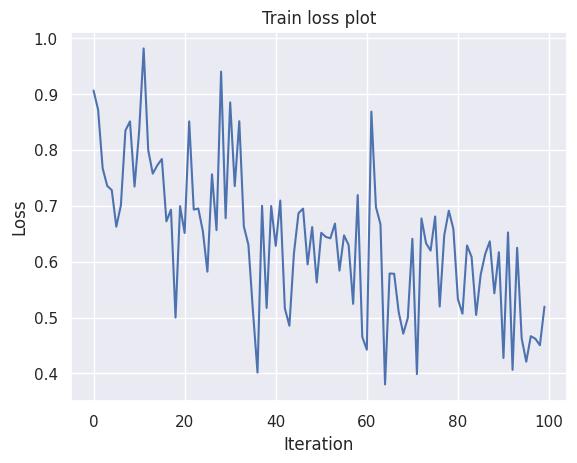

Text(0, 0.5, 'Loss')

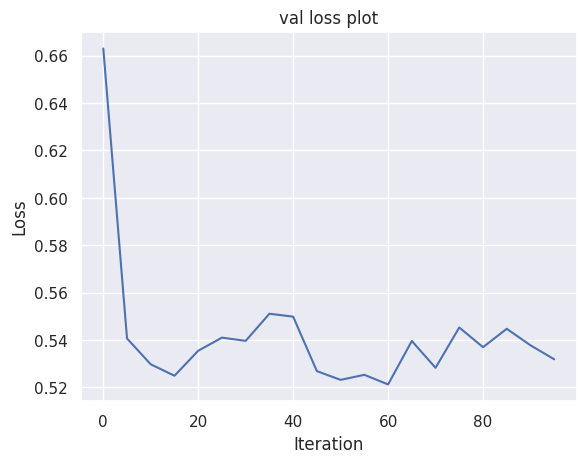

In [91]:
ax = plt.subplot()
sns.lineplot(x=range(100), y=losses_train ,ax = ax)
ax.set_title("Train loss plot")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()
ax = plt.subplot()
sns.lineplot(x=[i*5 for i in range(20)], y=losses_val ,ax = ax)
ax.set_title("val loss plot")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")